In [16]:
!pip install diffusers transformers accelerate adversarial-robustness-toolbox torch torchvision matplotlib numpy

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from diffusers import Transformer2DModel, AutoencoderKL, DDPMScheduler
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ({torch.cuda.device_count()} GPUs)")

Using device: cuda (2 GPUs)


In [17]:
BATCH_SIZE = 32

TRAIN_ROOT = '/kaggle/input/imagenet100/train.X1' 
VAL_ROOT   = '/kaggle/input/imagenet100/val.X'

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

print("Loading Training Metadata...")
train_dataset = torchvision.datasets.ImageFolder(
    root=TRAIN_ROOT,
    transform=transform_test
)
train_classes = set(train_dataset.classes)
print(f"Training classes found: {len(train_classes)}")

print("Filtering Validation Set...")
full_test_dataset = torchvision.datasets.ImageFolder(
    root=VAL_ROOT,
    transform=transform_test
)

valid_indices = []
test_to_train_map = {} 
test_classes = full_test_dataset.classes

for i, (path, test_label_idx) in enumerate(full_test_dataset.samples):
    class_name = test_classes[test_label_idx]
    
    if class_name in train_classes:
        valid_indices.append(i)
        train_label_idx = train_dataset.class_to_idx[class_name]
        test_to_train_map[test_label_idx] = train_label_idx

test_dataset = Subset(full_test_dataset, valid_indices)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

print(f"Filtered Test Set Size: {len(test_dataset)} images")

Loading Training Metadata...
Training classes found: 25
Filtering Validation Set...
Filtered Test Set Size: 1250 images


In [18]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor(std).view(1, 3, 1, 1))

    def forward(self, x):
        return (x - self.mean) / self.std

class BinaryWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        logits = self.model(x)
        return torch.cat([-logits, logits], dim=1)

def smart_load(model, path):
    if not os.path.exists(path):
        print(f"WARNING: {path} not found. Using random weights.")
        return

    state_dict = torch.load(path, map_location=device)
    if isinstance(state_dict, dict) and 'model_state' in state_dict:
        state_dict = state_dict['model_state']

    new_state_dict = {}
    for k, v in state_dict.items():
        name = k
        if name.startswith('module.'): name = name[7:]
        if name.startswith('1.'): name = name[2:]
        elif name.startswith('0.'): continue 
        if 'fc.0.' in name: name = name.replace('fc.0.', 'fc.')
        new_state_dict[name] = v

    model_state = model.state_dict()
    filtered_state_dict = {}
    
    for name, param in new_state_dict.items():
        if name in model_state:
            if param.shape == model_state[name].shape:
                filtered_state_dict[name] = param
            else:
                print(f"   ! Skipping {name}: Shape mismatch {param.shape} vs {model_state[name].shape}")
        else:
            pass

    model.load_state_dict(filtered_state_dict, strict=False)
    print(f"   -> Loaded matching weights from: {os.path.basename(path)}")


print("1. Loading Baseline Model...")
base_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
base_net.fc = nn.Linear(base_net.fc.in_features, len(train_classes)) 

smart_load(base_net, "/kaggle/input/the-weights/resnet18_25classes.pth")

baseline_model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    base_net
).to(device)
baseline_model.eval()


print("2. Loading Detection Model...")
detector_net = models.resnet18(weights=None)

detector_net.fc = nn.Linear(detector_net.fc.in_features, 2) 

smart_load(detector_net, "/kaggle/input/the-weights/detection_resnet_imagenet100.pth") 

detector_model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    detector_net
).to(device)
detector_model.eval()


print("3. Loading Mitigation Model (MART)...")
mitigation_net = models.resnet18(weights=None)
mitigation_net.fc = nn.Linear(mitigation_net.fc.in_features, len(train_classes))

smart_load(mitigation_net, "/kaggle/input/the-weights/mart_awp_resnet18_imagenet100.pth")

mitigation_model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    mitigation_net
).to(device)
mitigation_model.eval()

print("All Models Ready.")

1. Loading Baseline Model...
   -> Loaded matching weights from: resnet18_25classes.pth
2. Loading Detection Model...
   -> Loaded matching weights from: detection_resnet_imagenet100.pth
3. Loading Mitigation Model (MART)...
   ! Skipping fc.weight: Shape mismatch torch.Size([100, 512]) vs torch.Size([25, 512])
   ! Skipping fc.bias: Shape mismatch torch.Size([100]) vs torch.Size([25])
   -> Loaded matching weights from: mart_awp_resnet18_imagenet100.pth
All Models Ready.


In [19]:
print("Fixing Mitigation Model Head (Fine-tuning for 25 classes)...")

for param in mitigation_model.parameters():
    param.requires_grad = False

for param in mitigation_model[1].fc.parameters():
    param.requires_grad = True

optimizer_fix = optim.Adam(mitigation_model[1].fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_fix_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

mitigation_model.train()
EPOCHS = 2

for epoch in range(EPOCHS):
    loop = tqdm(train_fix_loader, desc=f"Fine-tuning Head {epoch+1}/{EPOCHS}")
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_fix.zero_grad()
        outputs = mitigation_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_fix.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        loop.set_postfix({'Loss': running_loss/len(loop), 'Acc': 100.*correct/total})

print("Mitigation Model is now ready for the 25-class pipeline!")
mitigation_model.eval()

Fixing Mitigation Model Head (Fine-tuning for 25 classes)...


Fine-tuning Head 1/2:   0%|          | 0/508 [00:00<?, ?it/s]

Fine-tuning Head 2/2:   0%|          | 0/508 [00:00<?, ?it/s]

Mitigation Model is now ready for the 25-class pipeline!


Sequential(
  (0): Normalize()
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [20]:
class DiTWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, hidden_states, timestep, class_labels):
        output = self.model(hidden_states, timestep=timestep, class_labels=class_labels).sample
        if output.shape[1] == 8: 
            output, _ = output.chunk(2, dim=1)
        return output

print("Loading DiT & VAE for Purification...")

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to(device)
vae.requires_grad_(False)

base_transformer = Transformer2DModel.from_pretrained("facebook/DiT-XL-2-256", subfolder="transformer", torch_dtype=torch.float16).to(device)
base_transformer.requires_grad_(False)

if torch.cuda.device_count() > 1:
    transformer = nn.DataParallel(DiTWrapper(base_transformer))
else:
    transformer = DiTWrapper(base_transformer).to(device)

scheduler = DDPMScheduler.from_pretrained("facebook/DiT-XL-2-256", subfolder="scheduler")

@torch.no_grad()
def purify_image(image_tensor, vae, transformer, scheduler, timestep_strength, labels):
    image_tensor = image_tensor.to(device).half()
    labels = labels.to(device)

    x = torch.nn.functional.interpolate(image_tensor, size=(256, 256), mode='bilinear', align_corners=False)
    x = (x * 2.0) - 1.0 

    latents = vae.encode(x).latent_dist.sample() * vae.config.scaling_factor

    scheduler.set_timesteps(100) 
    
    t_start = int((timestep_strength / 100.0) * scheduler.config.num_train_timesteps)
    t_start = min(t_start, scheduler.config.num_train_timesteps - 1) # Safety clamp
    
    noise = torch.randn_like(latents)
    timesteps = torch.tensor([t_start], device=device).long()
    noisy_latents = scheduler.add_noise(latents, noise, timesteps)
    
    inference_steps = scheduler.timesteps[scheduler.timesteps < t_start]

    current_latents = noisy_latents
    
    for t in inference_steps:
        t_batch = torch.full((current_latents.size(0),), t, device=device, dtype=torch.long)
        model_output = transformer(current_latents, t_batch, class_labels=labels)
        current_latents = scheduler.step(model_output, t, current_latents).prev_sample

    image_decoded = vae.decode(current_latents / vae.config.scaling_factor).sample
    image_decoded = (image_decoded / 2.0) + 0.5 
    
    image_final = torch.nn.functional.interpolate(image_decoded, size=(224, 224), mode='bilinear', align_corners=False)
    
    return torch.clamp(image_final, 0, 1)

print("Purification Pipeline Ready.")

Loading DiT & VAE for Purification...


An error occurred while trying to fetch facebook/DiT-XL-2-256: facebook/DiT-XL-2-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Purification Pipeline Ready.


In [21]:
EPSILON = 8/255
STEPS = 10
STEP_SIZE = 2/255

classifier_art = PyTorchClassifier(
    model=baseline_model,
    loss=nn.CrossEntropyLoss(),
    optimizer=None,
    input_shape=(3, 224, 224),
    nb_classes=len(train_classes),
    clip_values=(0.0, 1.0),
    device_type=device.type
)

pgd_attack = ProjectedGradientDescent(
    estimator=classifier_art,
    eps=EPSILON,
    eps_step=STEP_SIZE,
    max_iter=STEPS,
    batch_size=BATCH_SIZE,
    verbose=False
)

print(f"Attack Setup: PGD (Eps={EPSILON:.3f}, Steps={STEPS})")

Attack Setup: PGD (Eps=0.031, Steps=10)


In [22]:
import requests

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet1k_indices = requests.get(url).json()
wnid_to_global = {wnid: int(idx) for idx, (wnid, _) in imagenet1k_indices.items()}

train_to_global_map = [wnid_to_global.get(wnid, 0) for wnid in train_dataset.classes]
train_to_global_tensor = torch.tensor(train_to_global_map, device=device)

metrics = {
    "total_clean_images": 0, "total_adv_images": 0,
    "clean_pipeline_acc": 0, "adv_pipeline_acc": 0,
    "router_clean_correct": 0, "router_adv_correct": 0,
}

DETECTION_THRESHOLD = 0.05 

print(f"Starting Final Pipeline (Threshold={DETECTION_THRESHOLD}) - CLEAN MODE...")
loop = tqdm(test_loader, desc="Running Pipeline")

for imgs, raw_labels in loop:
    labels = torch.tensor([test_to_train_map[l.item()] for l in raw_labels]).to(device)
    imgs_np = imgs.numpy()
    imgs_gpu = imgs.to(device)
    
    with torch.no_grad():
        adv_probs = torch.softmax(detector_model(imgs_gpu), dim=1)[:, 1]
        
        idx_to_pure = (adv_probs > DETECTION_THRESHOLD).nonzero(as_tuple=True)[0]
        idx_to_base = (adv_probs <= DETECTION_THRESHOLD).nonzero(as_tuple=True)[0]

        preds_clean = torch.zeros_like(labels)
        if len(idx_to_base) > 0:
            preds_clean[idx_to_base] = baseline_model(imgs_gpu[idx_to_base]).argmax(1)
        if len(idx_to_pure) > 0:
            labels_glob = train_to_global_tensor[labels[idx_to_pure]]
            purified = purify_image(imgs_gpu[idx_to_pure], vae, transformer, scheduler, 75, labels_glob)
            preds_clean[idx_to_pure] = mitigation_model(purified.float()).argmax(1)
            
        metrics["clean_pipeline_acc"] += (preds_clean == labels).sum().item()
        metrics["router_clean_correct"] += len(idx_to_base)
        metrics["total_clean_images"] += labels.size(0)

    adv_imgs_np = pgd_attack.generate(x=imgs_np, y=labels.cpu().numpy())
    
    adv_imgs_np = (adv_imgs_np * 255).round() / 255.0
    
    adv_tensor = torch.tensor(adv_imgs_np, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        adv_probs_adv = torch.softmax(detector_model(adv_tensor), dim=1)[:, 1]
        
        idx_to_pure_adv = (adv_probs_adv > DETECTION_THRESHOLD).nonzero(as_tuple=True)[0]
        idx_to_base_adv = (adv_probs_adv <= DETECTION_THRESHOLD).nonzero(as_tuple=True)[0]

        preds_adv = torch.zeros_like(labels)
        if len(idx_to_base_adv) > 0:
            preds_adv[idx_to_base_adv] = baseline_model(adv_tensor[idx_to_base_adv]).argmax(1)
        if len(idx_to_pure_adv) > 0:
            labels_glob = train_to_global_tensor[labels[idx_to_pure_adv]]
            purified_adv = purify_image(adv_tensor[idx_to_pure_adv], vae, transformer, scheduler, 75, labels_glob)
            preds_adv[idx_to_pure_adv] = mitigation_model(purified_adv.float()).argmax(1)

        metrics["adv_pipeline_acc"] += (preds_adv == labels).sum().item()
        metrics["router_adv_correct"] += len(idx_to_pure_adv)
        metrics["total_adv_images"] += labels.size(0)

    loop.set_postfix({
        "Clean": f"{100*metrics['clean_pipeline_acc']/metrics['total_clean_images']:.0f}%",
        "Adv": f"{100*metrics['adv_pipeline_acc']/metrics['total_adv_images']:.0f}%"
    })

total_clean = metrics["total_clean_images"]
total_adv = metrics["total_adv_images"]
caught = metrics["router_adv_correct"]
fixed = metrics["adv_pipeline_acc"]
restoration_rate = 100 * (fixed / caught) if caught > 0 else 0.0
false_alarm_rate = 100 - (100*metrics['router_clean_correct']/total_clean)

print("\n" + "="*40)
print("FINAL PIPELINE RESULTS")
print("="*40)
print(f"CLEAN ACCURACY:       {100*metrics['clean_pipeline_acc']/total_clean:.2f}%")
print(f"FALSE ALARM RATE:     {false_alarm_rate:.2f}%")
print("-" * 40)
print(f"ADV ACCURACY:         {100*metrics['adv_pipeline_acc']/total_adv:.2f}%")
print(f"DETECTION RATE:       {100*metrics['router_adv_correct']/total_adv:.2f}%")
print(f"RESTORATION SUCCESS:  {restoration_rate:.2f}%")
print("="*40)

Starting Final Pipeline (Threshold=0.05) - CLEAN MODE...


Running Pipeline:   0%|          | 0/40 [00:00<?, ?it/s]


FINAL PIPELINE RESULTS
CLEAN ACCURACY:       91.68%
FALSE ALARM RATE:     0.00%
----------------------------------------
ADV ACCURACY:         66.40%
DETECTION RATE:       85.60%
RESTORATION SUCCESS:  77.57%


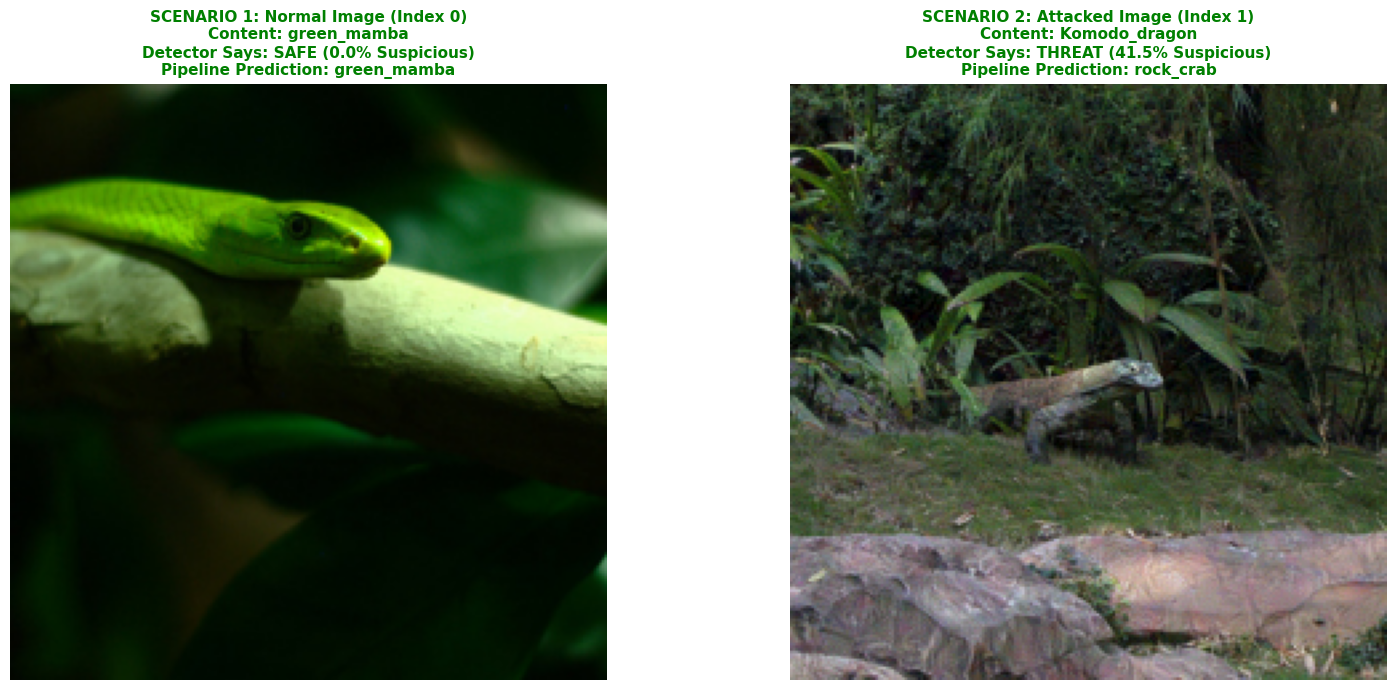

In [23]:
import random

idx = random.randint(0, len(labels) - 1)

def get_english_name(wnid_code):
    if 'imagenet1k_indices' in globals():
        for key, (wnid, name) in imagenet1k_indices.items():
            if wnid == wnid_code: return name
    return wnid_code

clean_img = imgs[idx].permute(1, 2, 0).cpu().numpy()
wnid_real = train_dataset.classes[labels[idx].item()]
name_real = get_english_name(wnid_real)
score_clean = adv_probs[idx].item()
pred_name_clean = get_english_name(train_dataset.classes[preds_clean[idx].item()])

adv_img = adv_imgs_np[idx].transpose(1, 2, 0)
score_adv = adv_probs_adv[idx].item()
pred_name_adv = get_english_name(train_dataset.classes[preds_adv[idx].item()])

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

status = "SAFE" if score_clean <= DETECTION_THRESHOLD else "FALSE ALARM"
color = 'green' if status == "SAFE" else 'red'
ax[0].imshow(np.clip(clean_img, 0, 1))
ax[0].set_title(f"Original: {name_real}\nDetector: {status} ({score_clean:.1%})\nPipeline Prediction: {pred_name_clean}", 
                color=color, fontweight='bold')
ax[0].axis('off')

status = "DETECTED" if score_adv > DETECTION_THRESHOLD else "MISSED"
color = 'green' if status == "DETECTED" else 'red'
ax[1].imshow(np.clip(adv_img, 0, 1))
ax[1].set_title(f"Adversarial Version\nDetector: {status} ({score_adv:.1%})\nPipeline Prediction: {pred_name_adv}", 
                color=color, fontweight='bold')
ax[1].axis('off')

plt.suptitle(f"System Check: Image Index {idx}", fontsize=16)
plt.tight_layout()
plt.show()